# Setup
Comment out javascript if jupyter widgets not installed

In [1]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
from pathlib import Path
from dataset import Video

# Create dataset
Creating data for input to the model is a little tricky. Details in the readme.

In [4]:
v_path = Path('/media/tris/tris_files/github/csce_courses/project_clean/videos/jpg_door/train') #in jpg format, from included script
a_path = Path('/media/tris/tris_files/github/csce_courses/project_clean/videos/jpg_door/labels.json') # in json format, from included script

In [5]:
from dataset_import import get_training_set, get_validation_set, get_test_set
from model import generate_model
class Args:
    dataset = 'kinetics'
    video_path = v_path
    annotation_path = a_path
    
input_args=Args()

In [6]:
from spatial_transforms2 import (
    Compose, Normalize, Scale, CenterCrop, CornerCrop, MultiScaleCornerCrop,
    MultiScaleRandomCrop, RandomHorizontalFlip, ToTensor)
from temporal_transforms2 import LoopPadding, TemporalRandomCrop
from target_transforms import ClassLabel, VideoID
from target_transforms import Compose as TargetCompose

In [7]:
norm_value=255 #for rgb data

scale_step=0.84089 #for the kinetics dataset
scales = [1]
n_scales=5
for i in range(1, n_scales):
    scales.append(scales[-1] * scale_step)
    
sample_size=112 # default for kinetics
sample_duration=4 # my choosen window size
norm_method = Normalize([110.636/norm_value, 103.1606/norm_value, 96.29/norm_value], 
                        [38.756/norm_value, 37.8824/norm_value, 40.03/norm_value]) #per the averages of the dataset
crop_method = MultiScaleRandomCrop(scales, sample_size)
spatial_transform = Compose([
            crop_method,
            RandomHorizontalFlip(),
            ToTensor(norm_value), norm_method])

In [8]:
temporal_transform = TemporalRandomCrop(sample_duration)
target_transform = ClassLabel()

In [9]:
training_data = get_training_set(input_args, spatial_transform,
                                 temporal_transform, target_transform)

dataset loading [0/73]


In [10]:
batch_size=16 #32 was too large!
n_threads=4
train_loader = torch.utils.data.DataLoader(
            training_data,
            batch_size=batch_size,
            shuffle=True,
            num_workers=n_threads,
            pin_memory=True)

# Validation Set
I have one video for training, another for test, and another for validation. Using the ActivityNet data crawler, these videos are easily transformed into the appropriate format as described in the readme.

In [11]:
v_path = Path('/media/tris/tris_files/github/csce_courses/project_clean/videos/jpg_door/val')
a_path = Path('/media/tris/tris_files/github/csce_courses/project_clean/videos/jpg_door/labels.json')

class Args:
    dataset = 'kinetics'
    video_path = v_path
    annotation_path = a_path
    n_val_samples=5
    sample_duration=4
    
val_args=Args()

In [12]:
validation_data = get_validation_set(
    val_args, spatial_transform, temporal_transform, target_transform)

dataset loading [0/26]


In [13]:
val_loader = torch.utils.data.DataLoader(
    validation_data,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True)

# Load Pre-Trained Model
### First, import kinetics pretrained model exactly as is

In [14]:
from models import resnet, pre_act_resnet, wide_resnet, resnext, densenet
import torch.nn as nn

model = resnext.resnet101(
    sample_size=112, #height and width of inputs
    sample_duration=4, #temporal, 16!!!
    num_classes=400) 

In [15]:
#from opts import parse_opts
from model import generate_model
class Args:
    sample_size = 112
    sample_duration = 4 #16!!!
    n_classes = 400
    mode='feature'
    model_name='resnext'
    model_depth=101
    resnet_shortcut='B'
    resnext_cardinality=32
    no_cuda=False
    batch_size=16
    n_threads=4

opt=Args()
model=generate_model(opt)

pretrain_path=Path('/media/tris/tris_files/github/csce_courses/video-classification-3d-cnn-pytorch/resnext-101-kinetics.pth')
model_data = torch.load(pretrain_path)
model.load_state_dict(model_data['state_dict'])
model.eval()

DataParallel(
  (module): ResNeXt(
    (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNeXtBottleneck(
        (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
        (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv3d(128, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

### With the model correcly imported, add a final layer to reduce the output size to my three desired outputs

In [16]:
for param in model.parameters():
    param.requires_grad = False
#     # Replace the last fully-connected layer
#     # Parameters of newly constructed modules have requires_grad=True by default
# model.fc = nn.Sequential(
#     nn.Linear(400, 256), #256 is arbitrary
#     nn.ReLU(),
#     nn.Linear(256,3),
#     nn.LogSoftmax(dim=1))
# model.fc.requires_grad=True
# model.cuda()
# model.eval()


In [17]:
my_module = nn.Sequential(
    nn.Linear(2048, 1200), #256 is arbitrary
    nn.ReLU(),
    nn.Linear(1200,256),
    nn.ReLU(),
    nn.Linear(256,3))
    #nn.Softmax(dim=1))#dim consider putting the softmax back in, unsure of dimension

In [18]:
my_model = nn.Sequential(model, my_module) #combining the pre-trained and new model
my_model.cuda() #put it on the gpu
my_model.eval()

Sequential(
  (0): DataParallel(
    (module): ResNeXt(
      (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): ResNeXtBottleneck(
          (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
          (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv3d(128, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine

### We now have the original model, plus a few extra layers to resize the output

In [19]:
from torch import optim# Loss and optimizer
from torch.optim import lr_scheduler
criterion = nn.CrossEntropyLoss()
criterion=criterion.cuda()

dampening=0 #0.9
optimizer = optim.SGD(
            my_model.parameters(),
            lr=3e-3,
            momentum=0.9,
            dampening=dampening,
            weight_decay=1e-3, #1e-3 #how important is this if I'm only training the last few layers? Set to 0?
            nesterov=False)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', patience=10)
# Definatley need some tuning here
    

In [20]:
from utils import Logger
import os
results_path=Path('/media/tris/tris_files/github/csce_courses/')

train_logger = Logger(os.path.join(results_path, 'train.log'),
                      ['epoch', 'loss', 'acc', 'lr'])
train_batch_logger = Logger(os.path.join(results_path, 'train_batch.log'),
                            ['epoch', 'batch', 'iter', 'loss', 'acc', 'lr'])
val_logger = Logger(
            os.path.join(results_path, 'val.log'), ['epoch', 'loss', 'acc'])

In [21]:
begin_epoch=1
n_epoch=150
from train2 import train_epoch
from validation import val_epoch

for i in range(begin_epoch, n_epoch + 1):
    train_epoch(i, train_loader, my_model, criterion, optimizer, opt,
                    train_logger, train_batch_logger)
    validation_loss = val_epoch(i, val_loader, my_model, criterion, opt,
                                    val_logger)
    scheduler.step(validation_loss)

train at epoch 1
Epoch: [1][1/5]	Time 0.760 (0.760)	Data 0.334 (0.334)	Loss 1.0767 (1.0767)	Acc 0.750 (0.750)
Epoch: [1][2/5]	Time 0.029 (0.395)	Data 0.002 (0.168)	Loss 1.0800 (1.0784)	Acc 0.625 (0.688)
Epoch: [1][3/5]	Time 0.093 (0.294)	Data 0.066 (0.134)	Loss 1.0638 (1.0735)	Acc 0.688 (0.688)
Epoch: [1][4/5]	Time 0.077 (0.240)	Data 0.050 (0.113)	Loss 1.0547 (1.0688)	Acc 0.688 (0.688)
Epoch: [1][5/5]	Time 0.077 (0.207)	Data 0.051 (0.101)	Loss 1.0716 (1.0691)	Acc 0.556 (0.671)
validation at epoch 1
Epoch: [1][1/9]	Time 0.429 (0.429)	Data 0.371 (0.371)	Loss 1.0093 (1.0093)	Acc 0.938 (0.938)
Epoch: [1][2/9]	Time 0.075 (0.252)	Data 0.022 (0.197)	Loss 1.0888 (1.0491)	Acc 0.438 (0.688)
Epoch: [1][3/9]	Time 0.081 (0.195)	Data 0.029 (0.141)	Loss 1.0507 (1.0496)	Acc 0.688 (0.688)
Epoch: [1][4/9]	Time 0.069 (0.164)	Data 0.027 (0.112)	Loss 1.0480 (1.0492)	Acc 0.688 (0.688)
Epoch: [1][5/9]	Time 0.062 (0.143)	Data 0.033 (0.096)	Loss 1.0469 (1.0487)	Acc 0.688 (0.688)
Epoch: [1][6/9]	Time 0.082 (0.1

Epoch: [7][4/5]	Time 0.079 (0.135)	Data 0.053 (0.107)	Loss 0.9656 (0.8441)	Acc 0.625 (0.688)
Epoch: [7][5/5]	Time 0.080 (0.124)	Data 0.055 (0.097)	Loss 1.0454 (0.8689)	Acc 0.556 (0.671)
validation at epoch 7
Epoch: [7][1/9]	Time 0.255 (0.255)	Data 0.213 (0.213)	Loss 0.6042 (0.6042)	Acc 0.938 (0.938)
Epoch: [7][2/9]	Time 0.098 (0.177)	Data 0.036 (0.125)	Loss 1.2211 (0.9126)	Acc 0.438 (0.688)
Epoch: [7][3/9]	Time 0.036 (0.130)	Data 0.016 (0.088)	Loss 0.9168 (0.9140)	Acc 0.688 (0.688)
Epoch: [7][4/9]	Time 0.075 (0.116)	Data 0.055 (0.080)	Loss 0.9033 (0.9114)	Acc 0.688 (0.688)
Epoch: [7][5/9]	Time 0.076 (0.108)	Data 0.056 (0.075)	Loss 0.8950 (0.9081)	Acc 0.688 (0.688)
Epoch: [7][6/9]	Time 0.074 (0.102)	Data 0.055 (0.072)	Loss 0.5069 (0.8412)	Acc 1.000 (0.740)
Epoch: [7][7/9]	Time 0.076 (0.099)	Data 0.057 (0.070)	Loss 0.6303 (0.8111)	Acc 0.875 (0.759)
Epoch: [7][8/9]	Time 0.073 (0.095)	Data 0.053 (0.068)	Loss 1.1148 (0.8491)	Acc 0.500 (0.727)
Epoch: [7][9/9]	Time 0.075 (0.093)	Data 0.056 (0

Epoch: [13][1/9]	Time 0.209 (0.209)	Data 0.178 (0.178)	Loss 0.4240 (0.4240)	Acc 0.938 (0.938)
Epoch: [13][2/9]	Time 0.075 (0.142)	Data 0.051 (0.114)	Loss 1.1749 (0.7995)	Acc 0.438 (0.688)
Epoch: [13][3/9]	Time 0.072 (0.119)	Data 0.052 (0.094)	Loss 0.7502 (0.7830)	Acc 0.688 (0.688)
Epoch: [13][4/9]	Time 0.074 (0.107)	Data 0.054 (0.084)	Loss 0.7607 (0.7775)	Acc 0.688 (0.688)
Epoch: [13][5/9]	Time 0.075 (0.101)	Data 0.055 (0.078)	Loss 0.8211 (0.7862)	Acc 0.688 (0.688)
Epoch: [13][6/9]	Time 0.074 (0.097)	Data 0.054 (0.074)	Loss 0.3615 (0.7154)	Acc 1.000 (0.740)
Epoch: [13][7/9]	Time 0.076 (0.094)	Data 0.055 (0.071)	Loss 0.5499 (0.6918)	Acc 0.875 (0.759)
Epoch: [13][8/9]	Time 0.076 (0.091)	Data 0.056 (0.069)	Loss 1.0419 (0.7355)	Acc 0.500 (0.727)
Epoch: [13][9/9]	Time 0.074 (0.089)	Data 0.055 (0.068)	Loss 0.3432 (0.7295)	Acc 1.000 (0.731)
train at epoch 14
Epoch: [14][1/5]	Time 0.199 (0.199)	Data 0.166 (0.166)	Loss 0.5870 (0.5870)	Acc 0.750 (0.750)
Epoch: [14][2/5]	Time 0.073 (0.136)	Data 0

Epoch: [19][4/9]	Time 0.077 (0.108)	Data 0.057 (0.080)	Loss 0.6908 (0.6566)	Acc 0.688 (0.688)
Epoch: [19][5/9]	Time 0.078 (0.102)	Data 0.058 (0.075)	Loss 0.7974 (0.6847)	Acc 0.750 (0.700)
Epoch: [19][6/9]	Time 0.075 (0.098)	Data 0.055 (0.072)	Loss 0.2560 (0.6133)	Acc 1.000 (0.750)
Epoch: [19][7/9]	Time 0.075 (0.095)	Data 0.055 (0.070)	Loss 0.6188 (0.6141)	Acc 0.750 (0.750)
Epoch: [19][8/9]	Time 0.078 (0.092)	Data 0.058 (0.068)	Loss 1.0477 (0.6683)	Acc 0.625 (0.734)
Epoch: [19][9/9]	Time 0.074 (0.090)	Data 0.054 (0.067)	Loss 0.1619 (0.6605)	Acc 1.000 (0.738)
train at epoch 20
Epoch: [20][1/5]	Time 0.203 (0.203)	Data 0.171 (0.171)	Loss 0.9243 (0.9243)	Acc 0.688 (0.688)
Epoch: [20][2/5]	Time 0.075 (0.139)	Data 0.050 (0.111)	Loss 0.5075 (0.7159)	Acc 0.688 (0.688)
Epoch: [20][3/5]	Time 0.080 (0.119)	Data 0.056 (0.092)	Loss 0.8006 (0.7441)	Acc 0.688 (0.688)
Epoch: [20][4/5]	Time 0.081 (0.110)	Data 0.056 (0.083)	Loss 0.6564 (0.7222)	Acc 0.688 (0.688)
Epoch: [20][5/5]	Time 0.079 (0.104)	Data 0

Epoch: [25][7/9]	Time 0.074 (0.091)	Data 0.055 (0.070)	Loss 0.6627 (0.5905)	Acc 0.625 (0.741)
Epoch: [25][8/9]	Time 0.073 (0.089)	Data 0.054 (0.068)	Loss 1.0718 (0.6506)	Acc 0.562 (0.719)
Epoch: [25][9/9]	Time 0.075 (0.088)	Data 0.055 (0.066)	Loss 0.1976 (0.6437)	Acc 1.000 (0.723)
train at epoch 26
Epoch: [26][1/5]	Time 0.199 (0.199)	Data 0.167 (0.167)	Loss 0.7447 (0.7447)	Acc 0.750 (0.750)
Epoch: [26][2/5]	Time 0.072 (0.136)	Data 0.047 (0.107)	Loss 0.5106 (0.6277)	Acc 0.812 (0.781)
Epoch: [26][3/5]	Time 0.081 (0.118)	Data 0.057 (0.090)	Loss 0.8555 (0.7036)	Acc 0.625 (0.729)
Epoch: [26][4/5]	Time 0.082 (0.109)	Data 0.058 (0.082)	Loss 0.9948 (0.7764)	Acc 0.688 (0.719)
Epoch: [26][5/5]	Time 0.078 (0.103)	Data 0.054 (0.076)	Loss 0.4087 (0.7311)	Acc 0.778 (0.726)
validation at epoch 26
Epoch: [26][1/9]	Time 0.198 (0.198)	Data 0.170 (0.170)	Loss 0.3647 (0.3647)	Acc 0.875 (0.875)
Epoch: [26][2/9]	Time 0.069 (0.134)	Data 0.046 (0.108)	Loss 0.9668 (0.6657)	Acc 0.438 (0.656)
Epoch: [26][3/9]	Ti

Epoch: [32][1/5]	Time 0.256 (0.256)	Data 0.224 (0.224)	Loss 0.7821 (0.7821)	Acc 0.625 (0.625)
Epoch: [32][2/5]	Time 0.084 (0.170)	Data 0.054 (0.139)	Loss 0.5810 (0.6816)	Acc 0.688 (0.656)
Epoch: [32][3/5]	Time 0.084 (0.141)	Data 0.054 (0.111)	Loss 0.7011 (0.6881)	Acc 0.688 (0.667)
Epoch: [32][4/5]	Time 0.076 (0.125)	Data 0.052 (0.096)	Loss 0.6069 (0.6678)	Acc 0.750 (0.688)
Epoch: [32][5/5]	Time 0.077 (0.115)	Data 0.054 (0.088)	Loss 0.8255 (0.6872)	Acc 0.667 (0.685)
validation at epoch 32
Epoch: [32][1/9]	Time 0.260 (0.260)	Data 0.232 (0.232)	Loss 0.3502 (0.3502)	Acc 0.875 (0.875)
Epoch: [32][2/9]	Time 0.079 (0.169)	Data 0.056 (0.144)	Loss 0.9587 (0.6544)	Acc 0.500 (0.688)
Epoch: [32][3/9]	Time 0.076 (0.138)	Data 0.055 (0.115)	Loss 0.5753 (0.6281)	Acc 0.750 (0.708)
Epoch: [32][4/9]	Time 0.074 (0.122)	Data 0.054 (0.099)	Loss 0.5313 (0.6039)	Acc 0.688 (0.703)
Epoch: [32][5/9]	Time 0.073 (0.112)	Data 0.053 (0.090)	Loss 0.8284 (0.6488)	Acc 0.688 (0.700)
Epoch: [32][6/9]	Time 0.074 (0.106)	D

Epoch: [38][4/5]	Time 0.086 (0.120)	Data 0.061 (0.094)	Loss 0.4705 (0.6212)	Acc 0.750 (0.781)
Epoch: [38][5/5]	Time 0.084 (0.113)	Data 0.060 (0.087)	Loss 0.5350 (0.6106)	Acc 0.889 (0.795)
validation at epoch 38
Epoch: [38][1/9]	Time 0.206 (0.206)	Data 0.174 (0.174)	Loss 0.3019 (0.3019)	Acc 0.938 (0.938)
Epoch: [38][2/9]	Time 0.066 (0.136)	Data 0.043 (0.109)	Loss 0.9381 (0.6200)	Acc 0.750 (0.844)
Epoch: [38][3/9]	Time 0.073 (0.115)	Data 0.053 (0.090)	Loss 0.6139 (0.6180)	Acc 0.688 (0.792)
Epoch: [38][4/9]	Time 0.076 (0.105)	Data 0.056 (0.082)	Loss 0.6007 (0.6136)	Acc 0.875 (0.812)
Epoch: [38][5/9]	Time 0.075 (0.099)	Data 0.055 (0.076)	Loss 0.8913 (0.6692)	Acc 0.625 (0.775)
Epoch: [38][6/9]	Time 0.076 (0.095)	Data 0.056 (0.073)	Loss 0.2671 (0.6022)	Acc 1.000 (0.812)
Epoch: [38][7/9]	Time 0.074 (0.092)	Data 0.054 (0.070)	Loss 0.6624 (0.6108)	Acc 0.688 (0.795)
Epoch: [38][8/9]	Time 0.077 (0.090)	Data 0.057 (0.068)	Loss 0.8910 (0.6458)	Acc 0.562 (0.766)
Epoch: [38][9/9]	Time 0.079 (0.089)	D

Epoch: [44][1/9]	Time 0.212 (0.212)	Data 0.167 (0.167)	Loss 0.4205 (0.4205)	Acc 0.938 (0.938)
Epoch: [44][2/9]	Time 0.053 (0.133)	Data 0.031 (0.099)	Loss 0.9497 (0.6851)	Acc 0.375 (0.656)
Epoch: [44][3/9]	Time 0.071 (0.112)	Data 0.052 (0.083)	Loss 0.8051 (0.7251)	Acc 0.750 (0.688)
Epoch: [44][4/9]	Time 0.075 (0.103)	Data 0.056 (0.076)	Loss 0.6306 (0.7015)	Acc 0.688 (0.688)
Epoch: [44][5/9]	Time 0.075 (0.097)	Data 0.055 (0.072)	Loss 0.8320 (0.7276)	Acc 0.750 (0.700)
Epoch: [44][6/9]	Time 0.074 (0.093)	Data 0.055 (0.069)	Loss 0.3090 (0.6578)	Acc 0.938 (0.740)
Epoch: [44][7/9]	Time 0.074 (0.091)	Data 0.055 (0.067)	Loss 0.8033 (0.6786)	Acc 0.562 (0.714)
Epoch: [44][8/9]	Time 0.075 (0.089)	Data 0.056 (0.066)	Loss 1.0109 (0.7201)	Acc 0.625 (0.703)
Epoch: [44][9/9]	Time 0.075 (0.087)	Data 0.056 (0.065)	Loss 0.4646 (0.7162)	Acc 1.000 (0.708)
train at epoch 45
Epoch: [45][1/5]	Time 0.202 (0.202)	Data 0.174 (0.174)	Loss 1.0447 (1.0447)	Acc 0.562 (0.562)
Epoch: [45][2/5]	Time 0.076 (0.139)	Data 0

Epoch: [50][4/9]	Time 0.073 (0.102)	Data 0.054 (0.080)	Loss 0.7214 (0.6493)	Acc 0.688 (0.719)
Epoch: [50][5/9]	Time 0.074 (0.097)	Data 0.054 (0.075)	Loss 0.8186 (0.6831)	Acc 0.750 (0.725)
Epoch: [50][6/9]	Time 0.073 (0.093)	Data 0.054 (0.072)	Loss 0.3467 (0.6271)	Acc 1.000 (0.771)
Epoch: [50][7/9]	Time 0.074 (0.090)	Data 0.054 (0.069)	Loss 0.6754 (0.6340)	Acc 0.688 (0.759)
Epoch: [50][8/9]	Time 0.074 (0.088)	Data 0.055 (0.067)	Loss 0.8287 (0.6583)	Acc 0.688 (0.750)
Epoch: [50][9/9]	Time 0.074 (0.087)	Data 0.054 (0.066)	Loss 0.2957 (0.6527)	Acc 1.000 (0.754)
train at epoch 51
Epoch: [51][1/5]	Time 0.204 (0.204)	Data 0.177 (0.177)	Loss 0.9374 (0.9374)	Acc 0.500 (0.500)
Epoch: [51][2/5]	Time 0.075 (0.140)	Data 0.051 (0.114)	Loss 0.7918 (0.8646)	Acc 0.688 (0.594)
Epoch: [51][3/5]	Time 0.078 (0.119)	Data 0.054 (0.094)	Loss 0.5145 (0.7479)	Acc 0.875 (0.688)
Epoch: [51][4/5]	Time 0.078 (0.109)	Data 0.054 (0.084)	Loss 0.5520 (0.6989)	Acc 0.875 (0.734)
Epoch: [51][5/5]	Time 0.078 (0.103)	Data 0

Epoch: [56][7/9]	Time 0.074 (0.092)	Data 0.055 (0.071)	Loss 0.5839 (0.5990)	Acc 0.750 (0.768)
Epoch: [56][8/9]	Time 0.074 (0.090)	Data 0.055 (0.069)	Loss 0.8657 (0.6323)	Acc 0.625 (0.750)
Epoch: [56][9/9]	Time 0.073 (0.088)	Data 0.055 (0.067)	Loss 0.2566 (0.6265)	Acc 1.000 (0.754)
train at epoch 57
Epoch: [57][1/5]	Time 0.204 (0.204)	Data 0.174 (0.174)	Loss 0.6157 (0.6157)	Acc 0.688 (0.688)
Epoch: [57][2/5]	Time 0.075 (0.140)	Data 0.051 (0.113)	Loss 0.8047 (0.7102)	Acc 0.812 (0.750)
Epoch: [57][3/5]	Time 0.078 (0.119)	Data 0.054 (0.093)	Loss 0.6862 (0.7022)	Acc 0.750 (0.750)
Epoch: [57][4/5]	Time 0.078 (0.109)	Data 0.054 (0.083)	Loss 0.5731 (0.6699)	Acc 0.750 (0.750)
Epoch: [57][5/5]	Time 0.078 (0.102)	Data 0.054 (0.078)	Loss 0.4069 (0.6375)	Acc 0.889 (0.767)
validation at epoch 57
Epoch: [57][1/9]	Time 0.200 (0.200)	Data 0.175 (0.175)	Loss 0.2728 (0.2728)	Acc 0.938 (0.938)
Epoch: [57][2/9]	Time 0.075 (0.138)	Data 0.050 (0.112)	Loss 0.9041 (0.5884)	Acc 0.438 (0.688)
Epoch: [57][3/9]	Ti

Epoch: [63][1/5]	Time 0.201 (0.201)	Data 0.171 (0.171)	Loss 0.8071 (0.8071)	Acc 0.688 (0.688)
Epoch: [63][2/5]	Time 0.075 (0.138)	Data 0.051 (0.111)	Loss 0.5729 (0.6900)	Acc 0.625 (0.656)
Epoch: [63][3/5]	Time 0.092 (0.123)	Data 0.068 (0.097)	Loss 0.5416 (0.6405)	Acc 0.875 (0.729)
Epoch: [63][4/5]	Time 0.085 (0.113)	Data 0.062 (0.088)	Loss 0.6825 (0.6510)	Acc 0.750 (0.734)
Epoch: [63][5/5]	Time 0.079 (0.106)	Data 0.055 (0.081)	Loss 0.6840 (0.6551)	Acc 0.667 (0.726)
validation at epoch 63
Epoch: [63][1/9]	Time 0.220 (0.220)	Data 0.173 (0.173)	Loss 0.3753 (0.3753)	Acc 0.938 (0.938)
Epoch: [63][2/9]	Time 0.054 (0.137)	Data 0.031 (0.102)	Loss 0.8179 (0.5966)	Acc 0.438 (0.688)
Epoch: [63][3/9]	Time 0.071 (0.115)	Data 0.051 (0.085)	Loss 0.6271 (0.6068)	Acc 0.812 (0.729)
Epoch: [63][4/9]	Time 0.074 (0.105)	Data 0.055 (0.077)	Loss 0.6271 (0.6119)	Acc 0.688 (0.719)
Epoch: [63][5/9]	Time 0.078 (0.099)	Data 0.057 (0.073)	Loss 0.7214 (0.6338)	Acc 0.688 (0.713)
Epoch: [63][6/9]	Time 0.076 (0.095)	D

Epoch: [69][4/5]	Time 0.079 (0.108)	Data 0.055 (0.083)	Loss 0.7209 (0.6136)	Acc 0.750 (0.766)
Epoch: [69][5/5]	Time 0.078 (0.102)	Data 0.054 (0.077)	Loss 1.2406 (0.6909)	Acc 0.444 (0.726)
validation at epoch 69
Epoch: [69][1/9]	Time 0.200 (0.200)	Data 0.175 (0.175)	Loss 0.3633 (0.3633)	Acc 0.875 (0.875)
Epoch: [69][2/9]	Time 0.073 (0.136)	Data 0.050 (0.112)	Loss 0.9870 (0.6751)	Acc 0.438 (0.656)
Epoch: [69][3/9]	Time 0.071 (0.115)	Data 0.051 (0.092)	Loss 0.7284 (0.6929)	Acc 0.688 (0.667)
Epoch: [69][4/9]	Time 0.074 (0.104)	Data 0.054 (0.082)	Loss 0.6568 (0.6839)	Acc 0.625 (0.656)
Epoch: [69][5/9]	Time 0.074 (0.098)	Data 0.055 (0.077)	Loss 0.7482 (0.6967)	Acc 0.688 (0.663)
Epoch: [69][6/9]	Time 0.078 (0.095)	Data 0.059 (0.074)	Loss 0.3117 (0.6326)	Acc 1.000 (0.719)
Epoch: [69][7/9]	Time 0.074 (0.092)	Data 0.055 (0.071)	Loss 0.6399 (0.6336)	Acc 0.750 (0.723)
Epoch: [69][8/9]	Time 0.076 (0.090)	Data 0.057 (0.070)	Loss 0.7554 (0.6488)	Acc 0.750 (0.727)
Epoch: [69][9/9]	Time 0.073 (0.088)	D

Epoch: [75][1/9]	Time 0.201 (0.201)	Data 0.175 (0.175)	Loss 0.3859 (0.3859)	Acc 0.938 (0.938)
Epoch: [75][2/9]	Time 0.072 (0.137)	Data 0.049 (0.112)	Loss 0.9347 (0.6603)	Acc 0.500 (0.719)
Epoch: [75][3/9]	Time 0.071 (0.115)	Data 0.051 (0.092)	Loss 0.6700 (0.6635)	Acc 0.812 (0.750)
Epoch: [75][4/9]	Time 0.073 (0.104)	Data 0.054 (0.082)	Loss 0.6010 (0.6479)	Acc 0.750 (0.750)
Epoch: [75][5/9]	Time 0.074 (0.098)	Data 0.055 (0.077)	Loss 0.8067 (0.6796)	Acc 0.688 (0.738)
Epoch: [75][6/9]	Time 0.074 (0.094)	Data 0.055 (0.073)	Loss 0.2846 (0.6138)	Acc 1.000 (0.781)
Epoch: [75][7/9]	Time 0.073 (0.091)	Data 0.054 (0.070)	Loss 0.6379 (0.6172)	Acc 0.688 (0.768)
Epoch: [75][8/9]	Time 0.073 (0.089)	Data 0.054 (0.068)	Loss 0.9023 (0.6529)	Acc 0.500 (0.734)
Epoch: [75][9/9]	Time 0.073 (0.087)	Data 0.055 (0.067)	Loss 0.2609 (0.6468)	Acc 1.000 (0.738)
train at epoch 76
Epoch: [76][1/5]	Time 0.198 (0.198)	Data 0.168 (0.168)	Loss 0.8359 (0.8359)	Acc 0.688 (0.688)
Epoch: [76][2/5]	Time 0.073 (0.135)	Data 0

Epoch: [81][4/9]	Time 0.073 (0.104)	Data 0.054 (0.082)	Loss 0.6592 (0.6383)	Acc 0.750 (0.750)
Epoch: [81][5/9]	Time 0.074 (0.098)	Data 0.054 (0.076)	Loss 0.7180 (0.6542)	Acc 0.688 (0.738)
Epoch: [81][6/9]	Time 0.074 (0.094)	Data 0.055 (0.073)	Loss 0.3364 (0.6013)	Acc 1.000 (0.781)
Epoch: [81][7/9]	Time 0.073 (0.091)	Data 0.054 (0.070)	Loss 0.5411 (0.5927)	Acc 0.750 (0.777)
Epoch: [81][8/9]	Time 0.074 (0.089)	Data 0.055 (0.068)	Loss 0.9596 (0.6385)	Acc 0.688 (0.766)
Epoch: [81][9/9]	Time 0.073 (0.087)	Data 0.054 (0.067)	Loss 0.3160 (0.6336)	Acc 1.000 (0.769)
train at epoch 82
Epoch: [82][1/5]	Time 0.197 (0.197)	Data 0.166 (0.166)	Loss 0.9254 (0.9254)	Acc 0.625 (0.625)
Epoch: [82][2/5]	Time 0.074 (0.135)	Data 0.049 (0.108)	Loss 0.3936 (0.6595)	Acc 0.938 (0.781)
Epoch: [82][3/5]	Time 0.077 (0.116)	Data 0.054 (0.090)	Loss 0.7406 (0.6865)	Acc 0.625 (0.729)
Epoch: [82][4/5]	Time 0.078 (0.106)	Data 0.054 (0.081)	Loss 0.9996 (0.7648)	Acc 0.562 (0.688)
Epoch: [82][5/5]	Time 0.078 (0.101)	Data 0

Epoch: [87][7/9]	Time 0.078 (0.098)	Data 0.059 (0.076)	Loss 0.5785 (0.6014)	Acc 0.875 (0.777)
Epoch: [87][8/9]	Time 0.079 (0.096)	Data 0.059 (0.074)	Loss 0.8677 (0.6347)	Acc 0.688 (0.766)
Epoch: [87][9/9]	Time 0.079 (0.094)	Data 0.060 (0.072)	Loss 0.3049 (0.6296)	Acc 1.000 (0.769)
train at epoch 88
Epoch: [88][1/5]	Time 0.200 (0.200)	Data 0.168 (0.168)	Loss 0.6162 (0.6162)	Acc 0.750 (0.750)
Epoch: [88][2/5]	Time 0.074 (0.137)	Data 0.049 (0.109)	Loss 0.6393 (0.6278)	Acc 0.812 (0.781)
Epoch: [88][3/5]	Time 0.078 (0.117)	Data 0.054 (0.090)	Loss 1.0598 (0.7718)	Acc 0.625 (0.729)
Epoch: [88][4/5]	Time 0.078 (0.107)	Data 0.055 (0.081)	Loss 0.6156 (0.7327)	Acc 0.688 (0.719)
Epoch: [88][5/5]	Time 0.078 (0.101)	Data 0.054 (0.076)	Loss 0.5730 (0.7131)	Acc 0.889 (0.740)
validation at epoch 88
Epoch: [88][1/9]	Time 0.200 (0.200)	Data 0.176 (0.176)	Loss 0.3698 (0.3698)	Acc 0.938 (0.938)
Epoch: [88][2/9]	Time 0.076 (0.138)	Data 0.051 (0.113)	Loss 0.9303 (0.6501)	Acc 0.625 (0.781)
Epoch: [88][3/9]	Ti

Epoch: [94][1/5]	Time 0.209 (0.209)	Data 0.181 (0.181)	Loss 0.5339 (0.5339)	Acc 0.812 (0.812)
Epoch: [94][2/5]	Time 0.077 (0.143)	Data 0.052 (0.117)	Loss 0.6177 (0.5758)	Acc 0.812 (0.812)
Epoch: [94][3/5]	Time 0.078 (0.121)	Data 0.053 (0.096)	Loss 0.9729 (0.7082)	Acc 0.500 (0.708)
Epoch: [94][4/5]	Time 0.079 (0.111)	Data 0.056 (0.086)	Loss 0.5043 (0.6572)	Acc 0.875 (0.750)
Epoch: [94][5/5]	Time 0.078 (0.104)	Data 0.054 (0.079)	Loss 0.9040 (0.6876)	Acc 0.556 (0.726)
validation at epoch 94
Epoch: [94][1/9]	Time 0.197 (0.197)	Data 0.170 (0.170)	Loss 0.3491 (0.3491)	Acc 0.938 (0.938)
Epoch: [94][2/9]	Time 0.069 (0.133)	Data 0.047 (0.109)	Loss 0.9499 (0.6495)	Acc 0.500 (0.719)
Epoch: [94][3/9]	Time 0.072 (0.113)	Data 0.052 (0.090)	Loss 0.7470 (0.6820)	Acc 0.688 (0.708)
Epoch: [94][4/9]	Time 0.074 (0.103)	Data 0.055 (0.081)	Loss 0.6055 (0.6629)	Acc 0.625 (0.688)
Epoch: [94][5/9]	Time 0.074 (0.097)	Data 0.055 (0.076)	Loss 0.6846 (0.6672)	Acc 0.812 (0.713)
Epoch: [94][6/9]	Time 0.075 (0.094)	D

Epoch: [100][4/5]	Time 0.078 (0.106)	Data 0.054 (0.081)	Loss 0.7612 (0.6418)	Acc 0.812 (0.797)
Epoch: [100][5/5]	Time 0.079 (0.101)	Data 0.055 (0.076)	Loss 0.9723 (0.6826)	Acc 0.667 (0.781)
validation at epoch 100
Epoch: [100][1/9]	Time 0.201 (0.201)	Data 0.177 (0.177)	Loss 0.3431 (0.3431)	Acc 0.938 (0.938)
Epoch: [100][2/9]	Time 0.078 (0.140)	Data 0.052 (0.114)	Loss 0.8980 (0.6205)	Acc 0.625 (0.781)
Epoch: [100][3/9]	Time 0.067 (0.115)	Data 0.048 (0.092)	Loss 0.6725 (0.6378)	Acc 0.750 (0.771)
Epoch: [100][4/9]	Time 0.073 (0.105)	Data 0.054 (0.082)	Loss 0.7060 (0.6549)	Acc 0.688 (0.750)
Epoch: [100][5/9]	Time 0.073 (0.099)	Data 0.054 (0.077)	Loss 0.7182 (0.6675)	Acc 0.750 (0.750)
Epoch: [100][6/9]	Time 0.073 (0.094)	Data 0.054 (0.073)	Loss 0.3476 (0.6142)	Acc 1.000 (0.792)
Epoch: [100][7/9]	Time 0.073 (0.091)	Data 0.054 (0.070)	Loss 0.5645 (0.6071)	Acc 0.812 (0.795)
Epoch: [100][8/9]	Time 0.073 (0.089)	Data 0.054 (0.068)	Loss 0.7930 (0.6303)	Acc 0.688 (0.781)
Epoch: [100][9/9]	Time 0.0

Epoch: [106][4/5]	Time 0.078 (0.109)	Data 0.054 (0.083)	Loss 0.7175 (0.6591)	Acc 0.812 (0.781)
Epoch: [106][5/5]	Time 0.078 (0.102)	Data 0.055 (0.078)	Loss 0.4941 (0.6387)	Acc 0.889 (0.795)
validation at epoch 106
Epoch: [106][1/9]	Time 0.199 (0.199)	Data 0.170 (0.170)	Loss 0.3179 (0.3179)	Acc 1.000 (1.000)
Epoch: [106][2/9]	Time 0.069 (0.134)	Data 0.046 (0.108)	Loss 1.0139 (0.6659)	Acc 0.438 (0.719)
Epoch: [106][3/9]	Time 0.071 (0.113)	Data 0.052 (0.089)	Loss 0.5845 (0.6388)	Acc 0.812 (0.750)
Epoch: [106][4/9]	Time 0.073 (0.103)	Data 0.054 (0.080)	Loss 0.6141 (0.6326)	Acc 0.688 (0.734)
Epoch: [106][5/9]	Time 0.074 (0.097)	Data 0.055 (0.075)	Loss 0.7058 (0.6472)	Acc 0.812 (0.750)
Epoch: [106][6/9]	Time 0.073 (0.093)	Data 0.054 (0.072)	Loss 0.2630 (0.5832)	Acc 1.000 (0.792)
Epoch: [106][7/9]	Time 0.073 (0.090)	Data 0.055 (0.069)	Loss 0.6413 (0.5915)	Acc 0.750 (0.786)
Epoch: [106][8/9]	Time 0.075 (0.088)	Data 0.056 (0.068)	Loss 0.8584 (0.6249)	Acc 0.562 (0.758)
Epoch: [106][9/9]	Time 0.0

Epoch: [112][4/5]	Time 0.079 (0.110)	Data 0.054 (0.085)	Loss 0.8663 (0.6556)	Acc 0.562 (0.703)
Epoch: [112][5/5]	Time 0.078 (0.104)	Data 0.055 (0.079)	Loss 0.7388 (0.6658)	Acc 0.667 (0.699)
validation at epoch 112
Epoch: [112][1/9]	Time 0.197 (0.197)	Data 0.169 (0.169)	Loss 0.2804 (0.2804)	Acc 0.938 (0.938)
Epoch: [112][2/9]	Time 0.068 (0.132)	Data 0.047 (0.108)	Loss 0.9213 (0.6009)	Acc 0.438 (0.688)
Epoch: [112][3/9]	Time 0.072 (0.112)	Data 0.052 (0.089)	Loss 0.5887 (0.5968)	Acc 0.938 (0.771)
Epoch: [112][4/9]	Time 0.075 (0.103)	Data 0.054 (0.080)	Loss 0.6013 (0.5979)	Acc 0.750 (0.766)
Epoch: [112][5/9]	Time 0.071 (0.097)	Data 0.052 (0.075)	Loss 0.7340 (0.6251)	Acc 0.812 (0.775)
Epoch: [112][6/9]	Time 0.075 (0.093)	Data 0.056 (0.071)	Loss 0.2709 (0.5661)	Acc 1.000 (0.812)
Epoch: [112][7/9]	Time 0.073 (0.090)	Data 0.054 (0.069)	Loss 0.5277 (0.5606)	Acc 0.812 (0.813)
Epoch: [112][8/9]	Time 0.075 (0.088)	Data 0.055 (0.067)	Loss 0.9447 (0.6086)	Acc 0.625 (0.789)
Epoch: [112][9/9]	Time 0.0

Epoch: [118][4/5]	Time 0.082 (0.114)	Data 0.057 (0.089)	Loss 0.7673 (0.7723)	Acc 0.688 (0.688)
Epoch: [118][5/5]	Time 0.081 (0.107)	Data 0.057 (0.082)	Loss 0.3939 (0.7256)	Acc 1.000 (0.726)
validation at epoch 118
Epoch: [118][1/9]	Time 0.214 (0.214)	Data 0.180 (0.180)	Loss 0.3096 (0.3096)	Acc 0.938 (0.938)
Epoch: [118][2/9]	Time 0.078 (0.146)	Data 0.050 (0.115)	Loss 0.9969 (0.6533)	Acc 0.438 (0.688)
Epoch: [118][3/9]	Time 0.067 (0.120)	Data 0.047 (0.092)	Loss 0.7065 (0.6710)	Acc 0.750 (0.708)
Epoch: [118][4/9]	Time 0.073 (0.108)	Data 0.054 (0.083)	Loss 0.6235 (0.6591)	Acc 0.750 (0.719)
Epoch: [118][5/9]	Time 0.075 (0.101)	Data 0.055 (0.077)	Loss 0.7767 (0.6827)	Acc 0.750 (0.725)
Epoch: [118][6/9]	Time 0.079 (0.098)	Data 0.059 (0.074)	Loss 0.2942 (0.6179)	Acc 1.000 (0.771)
Epoch: [118][7/9]	Time 0.084 (0.096)	Data 0.064 (0.073)	Loss 0.5975 (0.6150)	Acc 0.750 (0.768)
Epoch: [118][8/9]	Time 0.079 (0.093)	Data 0.059 (0.071)	Loss 0.9849 (0.6612)	Acc 0.688 (0.758)
Epoch: [118][9/9]	Time 0.0

Epoch: [124][4/5]	Time 0.078 (0.108)	Data 0.055 (0.084)	Loss 0.6019 (0.6154)	Acc 0.875 (0.766)
Epoch: [124][5/5]	Time 0.078 (0.102)	Data 0.055 (0.078)	Loss 0.9029 (0.6508)	Acc 0.778 (0.767)
validation at epoch 124
Epoch: [124][1/9]	Time 0.196 (0.196)	Data 0.166 (0.166)	Loss 0.3177 (0.3177)	Acc 0.938 (0.938)
Epoch: [124][2/9]	Time 0.066 (0.131)	Data 0.045 (0.106)	Loss 0.9143 (0.6160)	Acc 0.438 (0.688)
Epoch: [124][3/9]	Time 0.072 (0.112)	Data 0.052 (0.088)	Loss 0.7181 (0.6500)	Acc 0.562 (0.646)
Epoch: [124][4/9]	Time 0.073 (0.102)	Data 0.054 (0.079)	Loss 0.6886 (0.6597)	Acc 0.625 (0.641)
Epoch: [124][5/9]	Time 0.074 (0.096)	Data 0.054 (0.074)	Loss 0.7392 (0.6756)	Acc 0.750 (0.663)
Epoch: [124][6/9]	Time 0.073 (0.092)	Data 0.054 (0.071)	Loss 0.3256 (0.6172)	Acc 1.000 (0.719)
Epoch: [124][7/9]	Time 0.073 (0.090)	Data 0.054 (0.069)	Loss 0.6201 (0.6176)	Acc 0.750 (0.723)
Epoch: [124][8/9]	Time 0.074 (0.088)	Data 0.055 (0.067)	Loss 0.8497 (0.6467)	Acc 0.625 (0.711)
Epoch: [124][9/9]	Time 0.0

Epoch: [130][4/5]	Time 0.077 (0.108)	Data 0.054 (0.082)	Loss 0.4458 (0.7187)	Acc 0.875 (0.750)
Epoch: [130][5/5]	Time 0.079 (0.102)	Data 0.055 (0.077)	Loss 0.3691 (0.6756)	Acc 0.889 (0.767)
validation at epoch 130
Epoch: [130][1/9]	Time 0.222 (0.222)	Data 0.187 (0.187)	Loss 0.3774 (0.3774)	Acc 0.938 (0.938)
Epoch: [130][2/9]	Time 0.072 (0.147)	Data 0.045 (0.116)	Loss 0.9854 (0.6814)	Acc 0.438 (0.688)
Epoch: [130][3/9]	Time 0.067 (0.121)	Data 0.048 (0.093)	Loss 0.6974 (0.6867)	Acc 0.812 (0.729)
Epoch: [130][4/9]	Time 0.073 (0.109)	Data 0.054 (0.083)	Loss 0.7029 (0.6907)	Acc 0.625 (0.703)
Epoch: [130][5/9]	Time 0.074 (0.102)	Data 0.054 (0.078)	Loss 0.7243 (0.6975)	Acc 0.750 (0.713)
Epoch: [130][6/9]	Time 0.077 (0.098)	Data 0.058 (0.074)	Loss 0.2864 (0.6289)	Acc 1.000 (0.760)
Epoch: [130][7/9]	Time 0.074 (0.094)	Data 0.054 (0.071)	Loss 0.7659 (0.6485)	Acc 0.750 (0.759)
Epoch: [130][8/9]	Time 0.073 (0.092)	Data 0.054 (0.069)	Loss 0.8282 (0.6710)	Acc 0.750 (0.758)
Epoch: [130][9/9]	Time 0.0

Epoch: [136][4/5]	Time 0.086 (0.115)	Data 0.062 (0.089)	Loss 0.7537 (0.7025)	Acc 0.625 (0.719)
Epoch: [136][5/5]	Time 0.083 (0.109)	Data 0.059 (0.083)	Loss 0.8372 (0.7191)	Acc 0.667 (0.712)
validation at epoch 136
Epoch: [136][1/9]	Time 0.208 (0.208)	Data 0.183 (0.183)	Loss 0.4396 (0.4396)	Acc 0.938 (0.938)
Epoch: [136][2/9]	Time 0.082 (0.145)	Data 0.055 (0.119)	Loss 0.8931 (0.6664)	Acc 0.500 (0.719)
Epoch: [136][3/9]	Time 0.069 (0.120)	Data 0.050 (0.096)	Loss 0.6700 (0.6676)	Acc 0.812 (0.750)
Epoch: [136][4/9]	Time 0.073 (0.108)	Data 0.054 (0.085)	Loss 0.7057 (0.6771)	Acc 0.625 (0.719)
Epoch: [136][5/9]	Time 0.074 (0.101)	Data 0.054 (0.079)	Loss 0.7674 (0.6952)	Acc 0.750 (0.725)
Epoch: [136][6/9]	Time 0.073 (0.097)	Data 0.054 (0.075)	Loss 0.2705 (0.6244)	Acc 1.000 (0.771)
Epoch: [136][7/9]	Time 0.074 (0.093)	Data 0.054 (0.072)	Loss 0.5073 (0.6077)	Acc 0.938 (0.795)
Epoch: [136][8/9]	Time 0.075 (0.091)	Data 0.056 (0.070)	Loss 0.8991 (0.6441)	Acc 0.562 (0.766)
Epoch: [136][9/9]	Time 0.0

Epoch: [142][4/5]	Time 0.078 (0.108)	Data 0.054 (0.083)	Loss 0.6177 (0.6625)	Acc 0.750 (0.734)
Epoch: [142][5/5]	Time 0.078 (0.102)	Data 0.055 (0.077)	Loss 1.0260 (0.7073)	Acc 0.667 (0.726)
validation at epoch 142
Epoch: [142][1/9]	Time 0.207 (0.207)	Data 0.175 (0.175)	Loss 0.3643 (0.3643)	Acc 0.938 (0.938)
Epoch: [142][2/9]	Time 0.070 (0.139)	Data 0.046 (0.111)	Loss 0.9430 (0.6536)	Acc 0.500 (0.719)
Epoch: [142][3/9]	Time 0.070 (0.116)	Data 0.050 (0.090)	Loss 0.7777 (0.6950)	Acc 0.812 (0.750)
Epoch: [142][4/9]	Time 0.077 (0.106)	Data 0.055 (0.082)	Loss 0.6981 (0.6958)	Acc 0.688 (0.734)
Epoch: [142][5/9]	Time 0.071 (0.099)	Data 0.051 (0.076)	Loss 0.7969 (0.7160)	Acc 0.812 (0.750)
Epoch: [142][6/9]	Time 0.073 (0.095)	Data 0.054 (0.072)	Loss 0.3152 (0.6492)	Acc 1.000 (0.792)
Epoch: [142][7/9]	Time 0.074 (0.092)	Data 0.055 (0.070)	Loss 0.5632 (0.6369)	Acc 0.812 (0.795)
Epoch: [142][8/9]	Time 0.076 (0.090)	Data 0.054 (0.068)	Loss 0.8690 (0.6659)	Acc 0.625 (0.773)
Epoch: [142][9/9]	Time 0.0

Epoch: [148][4/5]	Time 0.079 (0.109)	Data 0.055 (0.084)	Loss 0.3935 (0.5357)	Acc 0.938 (0.766)
Epoch: [148][5/5]	Time 0.078 (0.102)	Data 0.054 (0.078)	Loss 1.0250 (0.5960)	Acc 0.556 (0.740)
validation at epoch 148
Epoch: [148][1/9]	Time 0.207 (0.207)	Data 0.182 (0.182)	Loss 0.3829 (0.3829)	Acc 0.938 (0.938)
Epoch: [148][2/9]	Time 0.075 (0.141)	Data 0.049 (0.115)	Loss 0.9319 (0.6574)	Acc 0.500 (0.719)
Epoch: [148][3/9]	Time 0.068 (0.116)	Data 0.048 (0.093)	Loss 0.7133 (0.6761)	Acc 0.812 (0.750)
Epoch: [148][4/9]	Time 0.073 (0.106)	Data 0.054 (0.083)	Loss 0.6769 (0.6763)	Acc 0.688 (0.734)
Epoch: [148][5/9]	Time 0.078 (0.100)	Data 0.058 (0.078)	Loss 0.8498 (0.7110)	Acc 0.812 (0.750)
Epoch: [148][6/9]	Time 0.081 (0.097)	Data 0.062 (0.075)	Loss 0.2520 (0.6345)	Acc 1.000 (0.792)
Epoch: [148][7/9]	Time 0.079 (0.094)	Data 0.059 (0.073)	Loss 0.6258 (0.6332)	Acc 0.875 (0.804)
Epoch: [148][8/9]	Time 0.079 (0.093)	Data 0.060 (0.071)	Loss 0.8410 (0.6592)	Acc 0.750 (0.797)
Epoch: [148][9/9]	Time 0.0

In [22]:
v_path = Path('/media/tris/tris_files/github/csce_courses/project_clean/videos/jpg_door/val') # can also put the test data here, have included validation b.c. it has labels for comp.
a_path = Path('/media/tris/tris_files/github/csce_courses/project_clean/videos/jpg_door/labels.json')
import test
class Args:
    dataset = 'kinetics'
    test_subset='val'
    video_path = v_path
    annotation_path = a_path
    sample_duration=4
    
test_set_args=Args()

test_data = get_test_set(test_set_args, spatial_transform, temporal_transform,
                                 target_transform)

dataset loading [0/26]


In [23]:
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    pin_memory=True)

In [24]:
correct = 0
total = 0
pred_final=[]
label_final=[]
video_results=[]
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        labels=labels.cuda()
        outputs = my_model(images)
#         print(torch.max(outputs, 1))
#         print(outputs)
        conf, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        predicted=predicted.cuda()
        print(max(labels), max(predicted)) #for validation
#         print(pred_final) #for test (unlabeled)
        correct += (predicted == labels).sum().item()
 
        predicted=predicted.cpu()
        pred_final.append(max(predicted.data.numpy()))
        labels=labels.cpu()
        conf=conf.cpu()
        label_final.append(max(labels.data.numpy()))
        json_label=max(predicted.data.numpy())
        json_label=json_label.tolist()
        json_conf=max(conf.data.numpy())
        json_conf=json_conf.tolist()
        for i in range(3):
            video_results.append({'label': test_data.class_names[json_label], 'score': json_conf})

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
# I think there's a better way to print results, look into this

tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') t

tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(2, device='cuda:0')
tensor(0, device='cuda:0') tensor(2, device='cuda:0')
tensor(0, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(2, device='cuda:0')
tensor(1, device='cuda:0') tensor(0, device='cuda:0')
tensor(1, device='cuda:0') tensor(0, device='cuda:0')
tensor(1, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') t

In [25]:
video_results

[{'label': 'none', 'score': 1.760331392288208},
 {'label': 'none', 'score': 1.760331392288208},
 {'label': 'none', 'score': 1.760331392288208},
 {'label': 'none', 'score': 1.9353742599487305},
 {'label': 'none', 'score': 1.9353742599487305},
 {'label': 'none', 'score': 1.9353742599487305},
 {'label': 'none', 'score': 1.5752846002578735},
 {'label': 'none', 'score': 1.5752846002578735},
 {'label': 'none', 'score': 1.5752846002578735},
 {'label': 'none', 'score': 1.5388823747634888},
 {'label': 'none', 'score': 1.5388823747634888},
 {'label': 'none', 'score': 1.5388823747634888},
 {'label': 'none', 'score': 2.095703601837158},
 {'label': 'none', 'score': 2.095703601837158},
 {'label': 'none', 'score': 2.095703601837158},
 {'label': 'none', 'score': 1.656265377998352},
 {'label': 'none', 'score': 1.656265377998352},
 {'label': 'none', 'score': 1.656265377998352},
 {'label': 'none', 'score': 2.1404428482055664},
 {'label': 'none', 'score': 2.1404428482055664},
 {'label': 'none', 'score': 2

In [26]:
import json
with open(os.path.join(results_path,'validation_results.json'),
              'w') as f:
        json.dump(video_results, f)

In [27]:
test_data.class_names

{0: 'none', 1: 'leaving', 2: 'returning'}

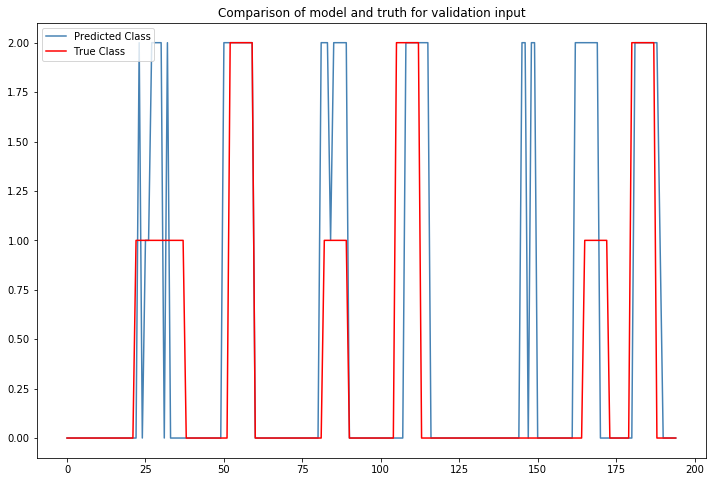

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(pred_final, color='steelblue')
ax.plot(label_final, color='red')
plt.title('Comparison of model and truth for validation input')
plt.legend(['Predicted Class','True Class'])
plt.show()

It's clear that the model is struggling to predict leaving vs entering. Overall, a good start, need more data

## Still a little bit of underfitting
- Areas for improvment
    - ~~More diverse dataset~~ (2020-04-01)
    - Hyperparameter tuning (some improvement 2020-04-04)
    - Make video window overlapping
    - ~~How to freeze some layers?~~ (2020-03-13)

In [29]:
weight_save_path=Path('/media/tris/tris_files/CSCE636-project-porta/porta.pth')
torch.save(my_model, weight_save_path)